# CS337 Project 9

In [1]:
%load_ext autoreload
import time
import numpy as np
from numpy.random import default_rng
from matplotlib import pyplot as plt

## Basic Simulation

This is the simplest model of a disk, based on the assumption that seek distance = seek time. This is obviously unrealistic, as it requires the reading head to always move at the same speed (no speeding up or slowing down).

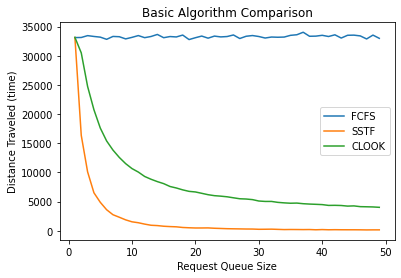

In [2]:
# import request generator and basic disk scheduling algorithms
from basic import basic_genreq, basic_fcfs, basic_sstf, basic_clook

seed = time.time_ns()

qsz = np.arange(1, 50)

results = []

for i in range(qsz.size):
 
    temp = np.zeros(3)

    for j in range(10):

        seed = time.time_ns()

        temp[0] += basic_fcfs(basic_genreq(100, 1000, seed))
        temp[1] += basic_sstf(basic_genreq(100, 1000, seed), qsz[i])
        temp[2] += basic_clook(basic_genreq(100, 1000, seed), qsz[i])

    results.append(temp/10)

results = np.asarray(results)

plt.plot(qsz, results[:,0], label = 'FCFS')
plt.plot(qsz, results[:,1], label = 'SSTF')
plt.plot(qsz, results[:,2], label = 'CLOOK')
plt.title('Basic Algorithm Comparison')
plt.xlabel('Request Queue Size')
plt.ylabel('Distance Traveled (time)')
plt.legend()
plt.savefig('Basic_Algorithm_Comparison.png', dpi=300)
plt.show()

## Better Disk Simulation

By making some physical assumptions about the disk we can do a much better. Here I am trying to approximate [this 3.5" 1TB hard drive](https://www.seagate.com/www-content/product-content/barracuda-fam/barracuda-new/en-us/docs/100804187a.pdf). Two helpful sources were [this](http://www2.cs.uh.edu/~paris/7360/PAPERS03/IEEEComputer.DiskModel.pdf) and [this](https://blog.stuffedcow.net/2019/09/hard-disk-geometry-microbenchmarking/).

**Assumptions:**
- Writeable area is a ring with ID of `35 mm` and OD of `91 mm`
- Arm acceleration of `30-40 g`  (`300000-400000 mm/s^2`)
- `352,000` tracks per inch * `2.204 in` (or `56 mm = 91 mm - 35 mm`) = `775808` tracks/surface
- 1TB is composed of `1953525168` 512-byte sectors or `244190646` 4096-byte sectors
- 1 platter with 2 surfaces each having `122095323` 4096-byte sectors

### Realistic Arm Movement

In [3]:
def arm_travel_ms(d_mm):
    '''
    to account for speedup + slowdown find time to accelerate to halfway point and double it
    '''
    a = 400000          # acceleration in mm/s^2
    t = (d_mm/a)**0.5   # find time to accelerate to halfway point
    t *= 2              # double it
    t *= 1000           # convert to ms
    return t

def seek_time_ms(track1, track2, RPM, rand, ovrhd_ms = 1):
    '''
    combine arm travel with overhead and random rotational delay
    '''
    mm_track = (25.4/352000)    # millimeters per track
    ms_rev = 1000*60/RPM        # ms per revolution

    d = np.abs(track1-track2)   # distance between tracks
    d_mm = d*mm_track           # convert to mm

    t = arm_travel_ms(d_mm)     # get travel time
    t += ovrhd_ms               # add overhead
    t += ms_rev*rand.random()   # add random rotational delay

    return t

### Plot Travel Time

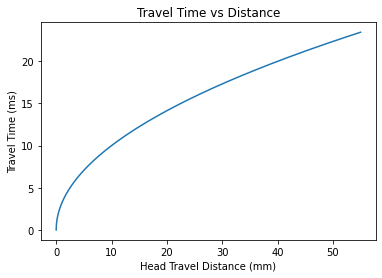

In [4]:
seek_dist_mm = np.linspace(0, 55, 1000)

plt.plot(seek_dist_mm, arm_travel_ms(seek_dist_mm))
plt.title('Travel Time vs Distance')
plt.xlabel('Head Travel Distance (mm)')
plt.ylabel('Travel Time (ms)')
plt.savefig('Travel_Time_vs_Distance.png', dpi=300)
plt.show()

### Plot Seek Time

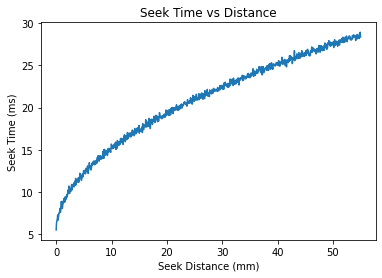

In [5]:
from numpy.random import default_rng

rand= default_rng()
track_dists = np.linspace(0, 55, 1000)
times=[]

for i in range(track_dists.size):
    temp = []

    for _ in range(100):
        temp.append(seek_time_ms(0, track_dists[i]*(352000/25.4), 7200, rand))

    times.append(np.sum(np.asarray(temp)/100))

plt.plot(track_dists, np.asarray(times))
plt.title('Seek Time vs Distance')
plt.xlabel('Seek Distance (mm)')
plt.ylabel('Seek Time (ms)')
plt.savefig('Seek_Time_vs_Distance.png', dpi=300)
plt.show()

### Simulate Zones

Zones are groups of tracks with the same number of sectors. This is done to maintain better area density. It also means that requests don't distribute evenly radially. 

To simulate zones:
- 122095323 4096 byte sectors
- 16 zones each with 48488 tracks

In [6]:
zones = np.linspace(35, 91, 17)

areas =[]
for i in range(16):
    areas.append(np.pi*zones[i+1]**2 - np.pi*zones[i]**2)

total = np.pi*zones[-1]**2 - np.pi*zones[0]**2

percentages = np.flip(np.asarray(areas)/total)

cummulative_percent = np.cumsum(percentages)

In [7]:
def gen_track(rand, percentages):

    rand_val = rand.random()

    for zone in range(16):
        
        if rand_val < percentages[zone]:

            break

    return zone*48488 + int(rand.random()*48488)

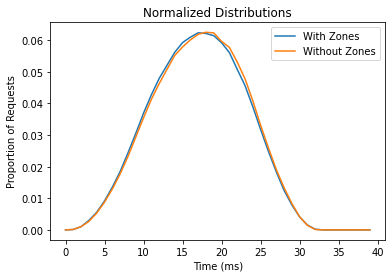

Average With Zones: 17.506954105693243 ms
Average Without Zones: 17.679005020388296 ms
Improvement: 0.17205091469505263 ms


In [8]:
rand= default_rng()

t_nozone = []
t_zone = []

for _ in range(1000000):

    loc1_zones = gen_track(rand, cummulative_percent)
    loc2_zones = gen_track(rand, cummulative_percent)

    t_zone.append(seek_time_ms(loc1_zones, loc2_zones, 7200, rand))
    
    locs_nozones = rand.random(2)*762205

    t_nozone.append(seek_time_ms(locs_nozones[0], locs_nozones[1], 7200, rand))

hist_zone, edges = np.histogram(t_zone, bins=40, range=(0,40))
hist_no_zone, edges = np.histogram(t_nozone, bins=40, range=(0,40))

avg_zone = np.mean(np.asarray(t_zone))
avg_nozone = np.mean(np.asarray(t_nozone))

plt.plot(np.arange(40), hist_zone/(1000000), label ='With Zones')
plt.plot(np.arange(40), hist_no_zone/(1000000), label ='Without Zones')
plt.title('Normalized Distributions')
plt.xlabel('Time (ms)')
plt.ylabel('Proportion of Requests')
plt.legend()
plt.savefig('Normalized_Distributions.png', dpi=300)
plt.show()

print('Average With Zones: '+str(avg_zone)+' ms\nAverage Without Zones: '+
        str(avg_nozone)+' ms\nImprovement: '+str(avg_nozone-avg_zone)+' ms')

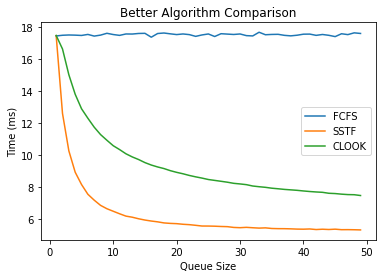

In [9]:
from better import better_fcfs, better_sstf, better_clook
from copy import deepcopy as dcp

rand = default_rng()

qsz = np.arange(1, 50)

results = []

for i in range(qsz.size):

    req = []

    for _ in range(10000):
        req.append(gen_track(rand, cummulative_percent))

    temp = np.zeros((3,2))

    for _ in range(10):

        fcfs_dist, fcfs_time = better_fcfs(dcp(req), seek_time_ms, rand)
        sstf_dist, sstf_time = better_sstf(dcp(req), qsz[i], seek_time_ms, rand)
        clook_dist, clook_time = better_clook(dcp(req), qsz[i], seek_time_ms, rand)

        temp[0][0] += fcfs_dist
        temp[0][1] += fcfs_time
        temp[1][0] += sstf_dist
        temp[1][1] += sstf_time
        temp[2][0] += clook_dist
        temp[2][1] += clook_time

    results.append(temp/100000)

results = np.asarray(results)

plt.plot(qsz, results[:,0][:,1], label = 'FCFS')
plt.plot(qsz, results[:,1][:,1], label = 'SSTF')
plt.plot(qsz, results[:,2][:,1], label = 'CLOOK')
plt.title('Better Algorithm Comparison')
plt.xlabel('Queue Size')
plt.ylabel('Time (ms)')
plt.legend()
plt.savefig('Better_Algorithm_Comparison.png', dpi=300)
plt.show()